# Part 1: Discharge Estimation and Numerical Integration

## Discharge Estimation by Dilution Gauging

In many hydrological and engineering applications, it is important to know how much water flows through a river or stream.
A simple method to estimate the discharge in small rivers and streams is so called dilution gauging.
In this method, a known amount of salt is added to the river and the concentration of the salt is measured downstream.

<center><img src="https://github.com/TUDelft-MUDE/source-files/raw/main/file/dilution_gauging.svg" width="50%"/></center>

Based on a mass balance, the discharge $Q$ [$\mathrm{L}^3 \mathrm{T}^{-1}$] can then be estimated from the injected mass $m [\mathrm{M}]$ and the area under the concentration curve $A$:

$$Q = \cfrac{m}{A} = \cfrac{m}{\int_0^{t_{\text{end}}} c(t) dt}$$

where $c(t) [\mathrm{M} \mathrm{L}^{-3}]$ is the concentration of salt in the river above the baseline level at time $t$ and $t_{\text{end}}$ is the end time of the measurement, well after the concentration returned to its baseline value.

The plot below shows such a concentration curve. In this assignment, you will determine the discharge based on this curve.
To evaluate the integral under the curve from the discrete measurements, you will have to use numerical integration techniques.

Text(0.5, 0, 'Time [s]')

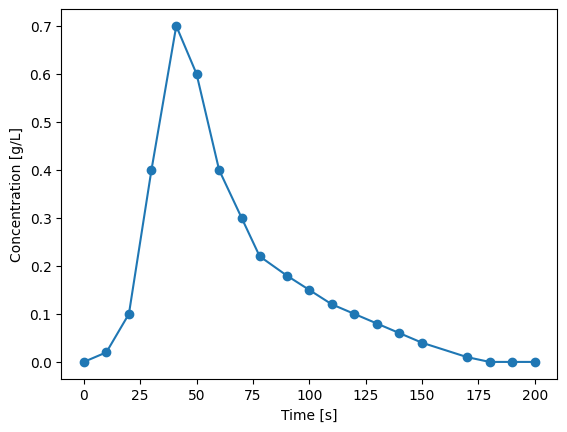

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# time in seconds
time = np.array([  0.,  10.,  20.,  30.,  41.,  50.,  60.,  70.,  78.,  90., 100.,
       110., 120., 130., 140., 150., 170., 180., 190., 200.])
# concentrations in g/L
concentration = np.array([0, 0.02, 0.1, 0.4, 0.7, 0.6, 0.4, 0.3, 0.22,
        0.18, 0.15, 0.12, 0.1, 0.08, 0.06, 0.04, 0.01, 0, 0, 0])
plt.plot(time, concentration, marker="o")
plt.ylabel("Concentration [g/L]")
plt.xlabel("Time [s]")

## Numerical Integration of the Concentration Curve

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.1**

Compute the area under the concentration curve by numerical integration. Compare two numerical integration methods of your choice.

</p>
</div>

In [2]:
# Compute the time difference between two consecutive points
dt = np.diff(time)

# Compute the area of the concentration curve with the trapezoidal rule
trapezoid_areas = (concentration[:-1] + concentration[1:]) / 2 * dt
total_area_trapz = np.sum(trapezoid_areas)

# Compute the area of the concentration curve with the left Riemann sum
total_area_left_riemann = np.sum(concentration[:-1] * dt)

# Compute the area of the concentration curve with the right Riemann sum
total_area_right_riemann = np.sum(concentration[1:] * dt)

print(
f"""
Total area under the concentration curve:
Left Riemann sum: {total_area_left_riemann:.2f} g/L s
Right Riemann sum: {total_area_right_riemann:.2f} g/L s
Trapezoidal rule: {total_area_trapz:.2f} g/L s
"""
)


Total area under the concentration curve:
Left Riemann sum: 34.74 g/L s
Right Riemann sum: 34.92 g/L s
Trapezoidal rule: 34.83 g/L s



<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.2**

Which integration method is best suited for this dataset? Why?

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">

**Solution 1.2**

For the dataset, the trapezoidal rule is suitable integration technique.
For a given number of integration points, it (theoretically) has a lower error compared to the left and right Riemann sum.

While Simpson's rule would have an even lower error, it requires equally spaced measurement intervals which are not available for this data set.
The error of the midpoint rule scales the same with the number of integration intervals as for the trapezoidal rule, but it requires evaluating the function at the midpoint of each interval. This is not possible with fixed measurements.
</p></div>

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.3**

Compute the discharge based on the concentration data. The amount of salt used tracer test is 200 g.

</p>
</div>

In [3]:
mass = 200 # g
discharge = mass / total_area_trapz # g / (g/L * s)
print(f"{discharge:.2f} L/s")

5.74 L/s


## Comparison of simulated and measured concentrations

To model the concentration curve, we fitted an analytical solution of the advection-dispersion-equation to the concentration data.
As a consistency if the model is a good approximation to the data, we want to compare the area under the simulated concentration curve to the area under the curve obtained with measurements.

Fitting models to data by parameter estimation will be a topic in later weeks of MUDE. For now, you do not need to understand how it works and do not need to modify the code on the cell below.

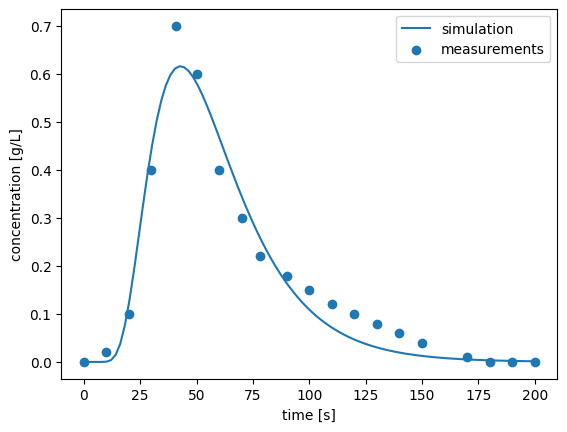

In [4]:
# You do not need to change anything in this cell

def advection_dispersion(t, x, v, D, m, A):
    """Compute the solution to the advection-dispersion equation"""
    def scalar(tt):
        """Piecewise definition for a single time point"""
        # For t=0, return the initial value
        if tt <= 0:
            return 0.0
        # Otherwise, compute the anaytical solution
        return (
            m / (A * v)
            * x / (np.sqrt(4 * np.pi * D * tt**3))
            * np.exp(-((x - v * tt) ** 2) / (4 * D * tt))
        ) / 1000 # convert from g/m³ to g/L

    f = np.vectorize(scalar, otypes=[float])
    return f(t)


# Fit the model to the data to obtain the parameters v, D and A
x = 20  # m
f = lambda time, v, D, A: advection_dispersion(time, x, v, D, mass, A)
popt, pcov = curve_fit(
    f, xdata=time, ydata=concentration, p0=(0.2, 1, 0.5), bounds=(0, np.inf)
)
v, D, area = popt  # units: m/s, m²/s, m²

# Plot the fitted curve along with the data
time_grid = np.linspace(0, time[-1], 100)
c_analytical = advection_dispersion(time_grid, x, v, D, mass, area)
plt.plot(time_grid, c_analytical, label="simulation")
plt.scatter(time, concentration, label="measurements")
plt.xlabel("time [s]")
plt.ylabel("concentration [g/L]")
plt.legend()



<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.4**
    
Evaluate the integral of the simulated concentration curve from time 0 to 200 seconds, using Simpson's rule.

Vary the number of integration intervals from 2 to 50. Why does the number of integration intervals have to be an even number?

Observe how the result changes with different numbers of integration intervals.
</p>
</div>

In [5]:
# Create an array of the number of integration intervals to test
intervals = np.arange(2, 50, step=2)

# Initialize a list to save the value of the integral for each number of integration intervals
integrals = []

for n_intervals in intervals:
    # Compute the interval length
    t_end = time[-1]
    dt = t_end / n_intervals
    # Evaluate the function at the required time points
    t = np.linspace(0, t_end, n_intervals+1)
    f_evaluated = advection_dispersion(t, x, v, D, mass, area)
    # Integrate the concentration curve with Simpson's rule
    terms = [
        (f_evaluated[2 * i - 2] + 4 * f_evaluated[2 * i - 1] + f_evaluated[2 * i]) / 6 * 2 * dt
        for i in range(1, n_intervals // 2 + 1)
    ]
    integral = sum(terms)
    # Save the value of the integral in the list
    integrals.append(integral)

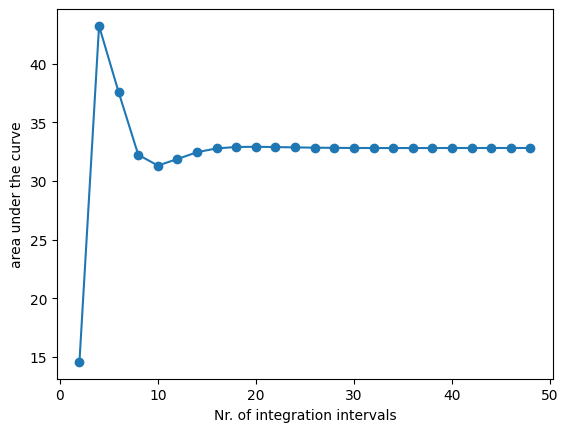

In [6]:
plt.plot(intervals, integrals, marker="o")
plt.xlabel("Nr. of integration intervals")
plt.ylabel("area under the curve");



<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Task 1.5**
    
Compare the integral of the simulated concentrations with the integral of the measurements. Are the areas approximately the same?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

**Solution 1.5**

The numerical integral of the measured curve is approximately 34.8, whereas the integral of the simulated curve is approximately 32.8.
Thus, the mass captured by the simulation is close to, but slightly less than the mass captured through measurements.
One reason for this mismatch is that the simulated curve does not exactly fit the shape of the measured curve

</p>
</div>

> By Anna Störiko, Ronald Brinkgreve, Justin Pittman, Jaime Arriaga Garcia, Robert Lanzafame, Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html).